<a href="https://colab.research.google.com/github/vkt1414/Cloud-Resources-Workflows/blob/main/Notebooks/Totalsegmentator/itkimage2segimageNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This Notebook does the last step in the split workflow on Terra

The NIFTI files generated from Totalsegmentator are provided as input and the DICOM files are downloaded again to generate DICOM SEG Objects

Please cite:
Herz C, Fillion-Robin JC, Onken M, Riesmeier J, Lasso A, Pinter C, Fichtinger G, Pieper S, Clunie D, Kikinis R, Fedorov A. dcmqi: An Open Source Library for Standardized Communication of Quantitative Image Analysis Results Using DICOM. Cancer Res. 2017 Nov 1;77(21):e87-e90. doi: 10.1158/0008-5472.CAN-17-0336. PMID: 29092948; PMCID: PMC5675033.

In [1]:
# import sys
# from pathlib import Path
# import time
# curr_dir   = Path().absolute()

# print(time.asctime(time.localtime()))
# print("\nCurrent directory :{}".format( curr_dir))
# print("Python version    :", sys.version.split('\n')[0])

Wed Mar 29 14:16:36 2023

Current directory :/content
Python version    : 3.9.16 (main, Dec  7 2022, 01:11:51) 


###Installing Packages

In [2]:
# %%capture
# #Installing lz4 for compression/decompression
# #xvfb required for previewing Totalsegmentator png images
# !apt-get install lz4 

In [3]:
# %%capture
# dcmqi_release_url = "https://github.com/QIICR/dcmqi/releases/download/v1.2.5/dcmqi-1.2.5-linux.tar.gz"
# dcmqi_download_path = f"{curr_dir}/dcmqi-1.2.5-linux.tar.gz"
# dcmqi_path = f"{curr_dir}/dcmqi-1.2.5-linux"

# !wget -O $dcmqi_download_path $dcmqi_release_url

# !tar -xvf $dcmqi_download_path 

# !mv $dcmqi_path/bin/* /bin
# !rm -r $dcmqi_download_path $dcmqi_path

In [4]:
# %%capture
# #install s5cmd
# !wget "https://github.com/peak/s5cmd/releases/download/v2.0.0/s5cmd_2.0.0_Linux-64bit.tar.gz"
# !tar -xvzf "s5cmd_2.0.0_Linux-64bit.tar.gz"
# !rm "s5cmd_2.0.0_Linux-64bit.tar.gz"
# !mv s5cmd /usr/local/bin/s5cmd

###Parameters

In [9]:
csvFilePath=''
inferenceNiftiFilePath=''

###Extracting Inference NIFTI files

In [6]:
import shutil
import glob
import os
try:
  shutil.rmtree(f'Inference')
except OSError:
  pass

#Get the file path of the inferenceNiftiFiles

#lz4_file_path = '/content/drive/MyDrive/idc_vamsi/inferenceNiftiFiles.tar.lz4'

!lz4 -d {inferenceNiftiFilePath} -c | tar --strip-components=0 -xvf -

#!lz4 -d /content/drive/MyDrive/idc_vamsi/inferenceNiftiFiles.tar.lz4 -c | tar xvf -

Inference/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.100327427105045277684804440612/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.100327427105045277684804440612/statistics_radiomics.json
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.100327427105045277684804440612/1.3.6.1.4.1.14519.5.2.1.7009.9004.100327427105045277684804440612.nii.lz4
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.100327427105045277684804440612/preview_total.png
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.246214778166486099453913994412/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.247849013724283526720822073721/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.247849013724283526720822073721/1.3.6.1.4.1.14519.5.2.1.7009.9004.247849013724283526720822073721.nii.lz4
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.247849013724283526720822073721/statistics_radiomics.json
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.247849013724283526720822073721/preview_total.png
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.140326800788968145134720737228/
I

###Reading CSV File containing s5cmd Urls

In [7]:
import sys
import time
import pandas as pd
from pathlib import Path

In [17]:
#get the path of the zip file containing csv file in the current working directory
#In Terra, a zip file containing the csv file will be provided as input and will be localized
#to the current working directory.

#Since it will be the only zip file that will be provided as input, we will be unzipping 
#the first zip file in the current working directory.

import glob

#zip_file_path = glob.glob('*.zip')[0]
#zip_file_path='/content/drive/MyDrive/result.zip'
#!unzip $zip_file_path

#csv_file_path = glob.glob('*.csv')[0]
#csv_file_path= '/home/vamsi/Downloads/result.csv'

start_time = time.time()
#cohort_df=pd.read_csv(csv_file_path, delimiter=',', encoding='utf-8')
#cohort_df= pd.read_csv('/content/drive/MyDrive/bquxjob_7f0d87d5_187056e0dd3.csv') #two nifti files example
#cohort_df= pd.read_csv('/content/drive/MyDrive/bq-results-20230315-160529-1678896367937/bq-results-20230315-160529-1678896367937.csv')
cohort_df=pd.read_csv(csvFilePath, delimiter=',', encoding='utf-8')
read_time=time.time() -start_time
print('read in '+str(read_time)+ '  seconds')  

read in 0.12382626533508301  seconds


###Functions

In [18]:
try:
  shutil.rmtree(f'itkimage2segimage')
except OSError:
  pass
os.mkdir(f'itkimage2segimage')

In [19]:
from concurrent.futures import ThreadPoolExecutor
from time import sleep
from datetime import datetime
import psutil
import time
import pandas as pd
import matplotlib.pyplot as plt

class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True

    def measure_usage(self):
        cpu_usage = []
        ram_usage_mb=[]
        disk_usage_all=[]
        time_stamps = []
        start_time = time.time()
        while self.keep_measuring:
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory()
            disk_used= psutil.disk_usage('/').used/1024/1024/1024
            disk_total= psutil.disk_usage('/').total/1024/1024/1024
            ram_total_mb = psutil.virtual_memory().total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024

            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            disk_usage_all.append(disk_used)

            time_stamps.append(time.time()- start_time)
            sleep(1)

        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb,  disk_usage_all, disk_total

In [20]:
def download_dicom_data(series_id):

  """
  Download raw DICOM data into "idc_data" folder.

  """
  try:
    shutil.rmtree(f'idc_data/{series_id}')
  except OSError:
    pass
  global cohort_df
  gs_file_path = "s5cmd_manifest.txt"
  #when bigquery is used the following line could be used
  #cohort_df = bq_client.query(selection_query).to_dataframe()
  series_df=cohort_df[cohort_df['SeriesInstanceUID']==series_id]
  series_df["s5cmdUrls"].to_csv(gs_file_path, header = False, index = False)
  #remove double quotes from the manifest file
  !sed -i 's/"//g' s5cmd_manifest.txt  

  start_time = time.time()
  print("Copying files from IDC buckets..")

  !s5cmd --no-sign-request --endpoint-url https://storage.googleapis.com run s5cmd_manifest.txt  >> /dev/null

  elapsed = time.time() - start_time
  print("Done in %g seconds."%elapsed)

In [21]:
try:
  os.remove(f'{curr_dir}/dicomseg_metadata_whole.json')
except OSError:
  pass
!wget https://raw.githubusercontent.com/vkt1414/models/main/models/totalsegmentator/config/dicomseg_metadata_whole.json

--2023-03-29 14:18:17--  https://raw.githubusercontent.com/vkt1414/models/main/models/totalsegmentator/config/dicomseg_metadata_whole.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80391 (79K) [text/plain]
Saving to: ‘dicomseg_metadata_whole.json’

dicomseg_metadata_w 100%[===================>]  78.51K  --.-KB/s    in 0.002s  

2023-03-29 14:18:17 (40.1 MB/s) - ‘dicomseg_metadata_whole.json’ saved [80391/80391]



In [22]:
def itkimage2segimage(series_id):
      try:
        shutil.rmtree(f'itkimage2segimage/{series_id}')
      except OSError:
        pass
        os.mkdir(f'itkimage2segimage/{series_id}')

      print("Processing series: "+series_id)  

      """
      Downloading DICOM files only for the Series with Totalsegmentator NIFTI files

      """
      download_dicom_data(series_id) 


      #Get Inference NIFTI file path
      inference_nifti_filename_path = os.path.join(curr_dir,'Inference', series_id, series_id+'.nii.lz4')
      inference_nifti_filename = os.path.join(curr_dir,'Inference', series_id, series_id+'.nii')
      inference_list = []
      inference_list.append(inference_nifti_filename)

      try:
        os.remove(inference_nifti_filename)
      except OSError:
        pass
      !lz4 -d {inference_nifti_filename_path}
      #remove the compressed file after decompressing
      !rm -r {inference_nifti_filename_path}
       
      start_time = time.time()
      !itkimage2segimage --inputImageList {inference_nifti_filename} --inputDICOMDirectory {curr_dir}/idc_data/{series_id}/ --outputDICOM {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm --inputMetadata {curr_dir}/dicomseg_metadata_whole.json --skip >> /dev/null
      itkimage2segimage_time = time.time() - start_time
      print("Done in %g seconds."%itkimage2segimage_time)

      start_time = time.time()     
      !lz4 {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm  {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm.lz4
      archiving_time = time.time() - start_time
      
      log = pd.DataFrame({'SeriesInstanceUID': [series_id]}) 
      log['itkimage2segimage_time']=itkimage2segimage_time
      log['archiving_time'] = archiving_time

      !rm -r {curr_dir}/Inference/{series_id}
      !rm -r {curr_dir}/idc_data/{series_id}
      !rm -r {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm
      global runtime_stats
      runtime_stats = pd.concat([runtime_stats, log], ignore_index=True, axis=0)

###Convert Inference NIFTI file to DICOM_SEG Object

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.247849013724283526720822073721
Copying files from IDC buckets..
Done in 1.32592 seconds.
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.247849013724283526720822073721/1.3.6.1.4.1.14519.5.2.1.7009.9004.247849013724283526720822073721.nii 
/content/Inference/1 : decoded 124267968 bytes 
Done in 92.4583 seconds.
Compressed 324015142 bytes into 1990268 bytes ==> 0.61%


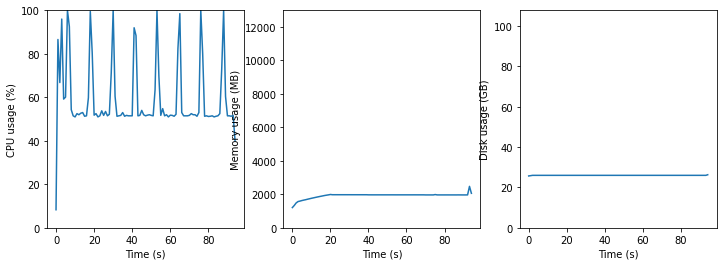

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.105995970447645784296049363569
Copying files from IDC buckets..
Done in 1.21788 seconds.
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.105995970447645784296049363569/1.3.6.1.4.1.14519.5.2.1.7009.9004.105995970447645784296049363569.nii.lz4: is not a regular file 
rm: cannot remove '/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.105995970447645784296049363569/1.3.6.1.4.1.14519.5.2.1.7009.9004.105995970447645784296049363569.nii.lz4': No such file or directory
Error: /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.105995970447645784296049363569/1.3.6.1.4.1.14519.5.2.1.7009.9004.105995970447645784296049363569.nii not found!
Done in 0.115857 seconds.
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.105995970447645784296049363569/1.3.6.1.4.1.14519.5.2.1.7009.9004.105995970447645784296049363569.dcm: is not a regular file 
rm: cannot remove '/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.10599597044

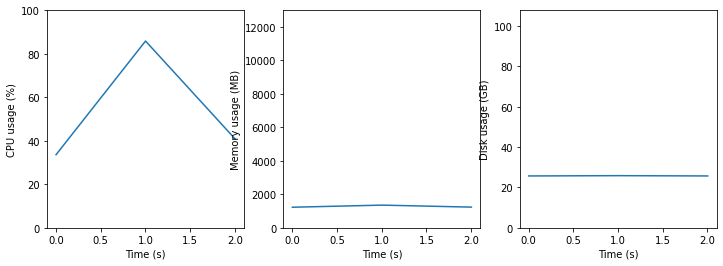

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.246214778166486099453913994412
Copying files from IDC buckets..
Done in 1.2305 seconds.
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.246214778166486099453913994412/1.3.6.1.4.1.14519.5.2.1.7009.9004.246214778166486099453913994412.nii.lz4: is not a regular file 
rm: cannot remove '/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.246214778166486099453913994412/1.3.6.1.4.1.14519.5.2.1.7009.9004.246214778166486099453913994412.nii.lz4': No such file or directory
Error: /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.246214778166486099453913994412/1.3.6.1.4.1.14519.5.2.1.7009.9004.246214778166486099453913994412.nii not found!
Done in 0.115195 seconds.
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.246214778166486099453913994412/1.3.6.1.4.1.14519.5.2.1.7009.9004.246214778166486099453913994412.dcm: is not a regular file 
rm: cannot remove '/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.246214778166

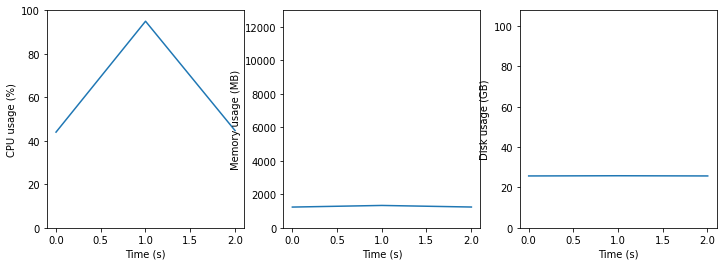

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.878577617372040773088707584895
Copying files from IDC buckets..
Done in 1.32099 seconds.
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.878577617372040773088707584895/1.3.6.1.4.1.14519.5.2.1.7009.9004.878577617372040773088707584895.nii.lz4: is not a regular file 
rm: cannot remove '/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.878577617372040773088707584895/1.3.6.1.4.1.14519.5.2.1.7009.9004.878577617372040773088707584895.nii.lz4': No such file or directory
Error: /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.878577617372040773088707584895/1.3.6.1.4.1.14519.5.2.1.7009.9004.878577617372040773088707584895.nii not found!
Done in 0.113955 seconds.
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.878577617372040773088707584895/1.3.6.1.4.1.14519.5.2.1.7009.9004.878577617372040773088707584895.dcm: is not a regular file 
rm: cannot remove '/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.87857761737

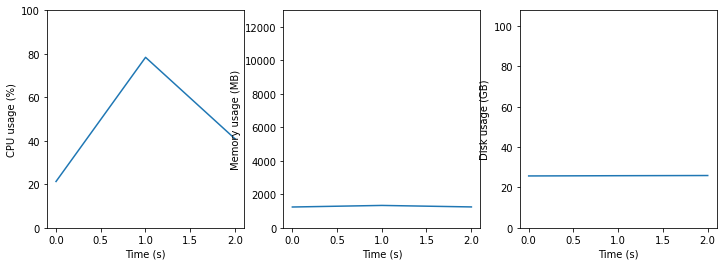

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.281898280341183311043321964677
Copying files from IDC buckets..
Done in 1.33101 seconds.
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.281898280341183311043321964677/1.3.6.1.4.1.14519.5.2.1.7009.9004.281898280341183311043321964677.nii 
/content/Inference/1 : decoded 124530112 bytes 
Done in 70.7711 seconds.
Compressed 310413648 bytes into 1977100 bytes ==> 0.64%


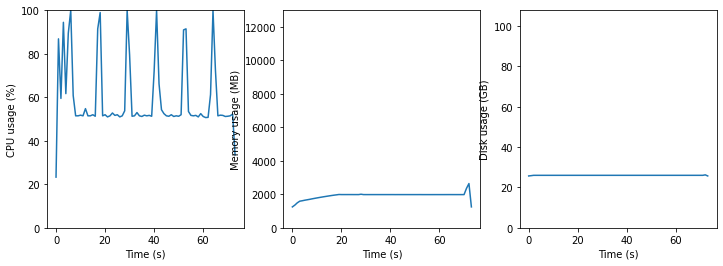

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.199068718159252822851241147187
Copying files from IDC buckets..
Done in 1.65007 seconds.
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.199068718159252822851241147187/1.3.6.1.4.1.14519.5.2.1.7009.9004.199068718159252822851241147187.nii 
/content/Inference/1 : decoded 104607168 bytes 
Done in 60.879 seconds.
Compressed 275212322 bytes into 1757748 bytes ==> 0.64%


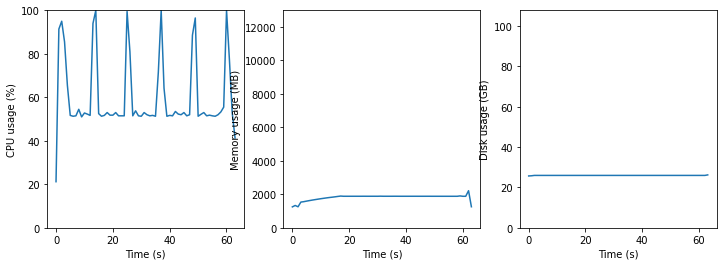

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.599359895747475354375211420207
Copying files from IDC buckets..
Done in 1.22796 seconds.
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.599359895747475354375211420207/1.3.6.1.4.1.14519.5.2.1.7009.9004.599359895747475354375211420207.nii 
/content/Inference/1 : decoded 122695104 bytes 
Done in 97.0886 seconds.
Compressed 330599214 bytes into 2045553 bytes ==> 0.62%


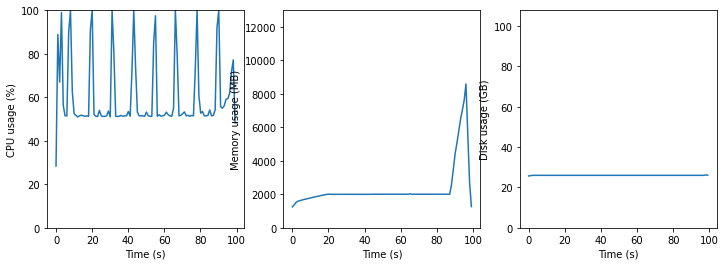

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.100327427105045277684804440612
Copying files from IDC buckets..
Done in 1.84452 seconds.
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.100327427105045277684804440612/1.3.6.1.4.1.14519.5.2.1.7009.9004.100327427105045277684804440612.nii 
/content/Inference/1 : decoded 108801472 bytes 
Done in 62.4735 seconds.
Compressed 266846186 bytes into 1761246 bytes ==> 0.66%


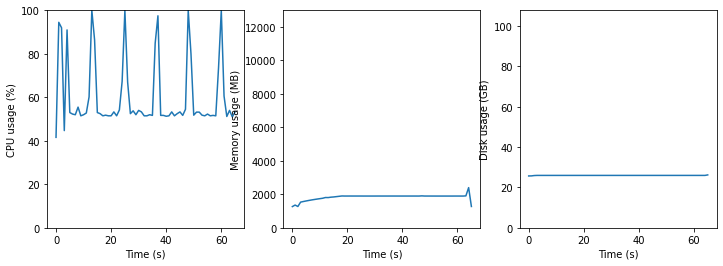

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.114231323042535257813505318334
Copying files from IDC buckets..
Done in 1.32859 seconds.
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.114231323042535257813505318334/1.3.6.1.4.1.14519.5.2.1.7009.9004.114231323042535257813505318334.nii 
/content/Inference/1 : decoded 120073664 bytes 
Done in 93.0984 seconds.
Compressed 322453068 bytes into 1992205 bytes ==> 0.62%


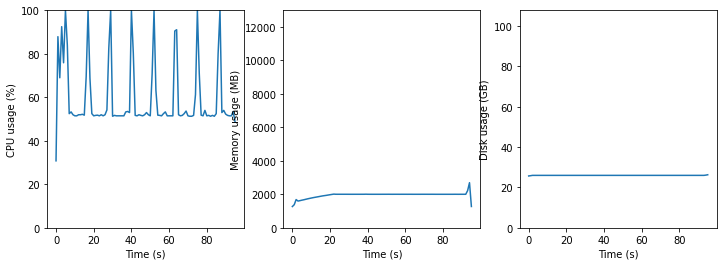

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.140326800788968145134720737228
Copying files from IDC buckets..
Done in 1.93576 seconds.
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.140326800788968145134720737228/1.3.6.1.4.1.14519.5.2.1.7009.9004.140326800788968145134720737228.nii.lz4: is not a regular file 
rm: cannot remove '/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.140326800788968145134720737228/1.3.6.1.4.1.14519.5.2.1.7009.9004.140326800788968145134720737228.nii.lz4': No such file or directory
Error: /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.140326800788968145134720737228/1.3.6.1.4.1.14519.5.2.1.7009.9004.140326800788968145134720737228.nii not found!
Done in 0.119123 seconds.
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.140326800788968145134720737228/1.3.6.1.4.1.14519.5.2.1.7009.9004.140326800788968145134720737228.dcm: is not a regular file 
rm: cannot remove '/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.14032680078

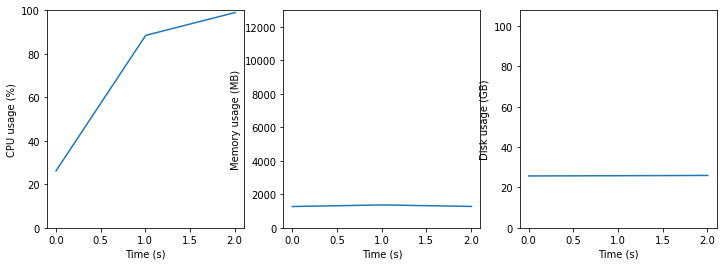

In [23]:

runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','itkimage2segimage_time',
                                      'archiving_time', 'cpu_usage','ram_usage_mb', 'ram_total_mb', 
                                      'disk_usage_all', 'disk_total'
                                      ])
if __name__ == "__main__":
    for series_id in os.listdir(f'Inference'):
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                proc_thread = executor.submit(itkimage2segimage, series_id)
                proc_thread.result()
            finally:
                monitor.keep_measuring = False
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, disk_usage_all, disk_total= mem_thread.result()
                
                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]
                
                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]

                disk_usage_gb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[disk_usage_gb_idx, runtime_stats.columns.get_loc('disk_usage_all')] = [[disk_usage_all]]

                runtime_stats['disk_total']=disk_total    

                fig, ((ax1,ax2, ax3)) = plt.subplots(1,3, figsize=(12, 4)) 

                ax1.plot(time_stamps, cpu_usage)
                ax1.set_ylim(0, 100)
                ax1.set_xlabel('Time (s)')
                ax1.set_ylabel('CPU usage (%)')

                ax2.plot(time_stamps, ram_usage_mb)
                ax2.set_ylim(0, ram_total_mb)
                ax2.set_xlabel('Time (s)')
                ax2.set_ylabel('Memory usage (MB)')

                ax3.plot(time_stamps, disk_usage_all)
                ax3.set_ylim(0, disk_total)
                ax3.set_xlabel('Time (s)')
                ax3.set_ylabel('Disk usage (GB)')
                plt.show()

###Compressing Output Files

In [26]:
start_time = time.time()
try:
  os.remove(f'{curr_dir}/itkimage2segimageDICOMsegFiles.tar.lz4')
except OSError:
  pass
!tar cvf - {curr_dir}/itkimage2segimage | lz4 > {curr_dir}/itkimage2segimageDICOMsegFiles.tar.lz4
archiving_time = time.time() - start_time

tar: Removing leading `/' from member names
/content/itkimage2segimage/
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.247849013724283526720822073721/
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.247849013724283526720822073721/1.3.6.1.4.1.14519.5.2.1.7009.9004.247849013724283526720822073721.dcm.lz4
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.105995970447645784296049363569/
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.246214778166486099453913994412/
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.878577617372040773088707584895/
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.281898280341183311043321964677/
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.281898280341183311043321964677/1.3.6.1.4.1.14519.5.2.1.7009.9004.281898280341183311043321964677.dcm.lz4
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.199068718159252822851241147187/
/content/itkimage2segimage/1.3.6.1.4.1.1

###Utilization Metrics

In [25]:
runtime_stats.to_csv('runtime.csv')
runtime_stats['archiving_time']=archiving_time
try:
  os.remove('itkimage2segimageUsageMetrics.lz4')
except OSError:
  pass
!lz4 {curr_dir}/runtime.csv itkimage2segimageUsageMetrics.lz4
runtime_stats

Compressed 21681 bytes into 6286 bytes ==> 28.99%


,SeriesInstanceUID,itkimage2segimage_time,archiving_time,cpu_usage,ram_usage_mb,ram_total_mb,disk_usage_all,disk_total
0,1.3.6.1.4.1.14519.5.2.1.7009.9004.247849013724...,92.458291,0.117637,"[[[8.3, 86.6, 66.8, 96.0, 59.2, 60.1, 100.0, 9...","[[[1207.65234375, 1334.6328125, 1485.71875, 15...",[12985.546875],"[[[25.686447143554688, 25.821491241455078, 25....",107.715084
1,1.3.6.1.4.1.14519.5.2.1.7009.9004.105995970447...,0.115857,0.117637,"[[[33.6, 85.9, 40.9]]]","[[[1228.09765625, 1354.41796875, 1235.12109375]]]",[12985.546875],"[[[25.685897827148438, 25.828083038330078, 25....",107.715084
2,1.3.6.1.4.1.14519.5.2.1.7009.9004.246214778166...,0.115195,0.117637,"[[[44.0, 95.0, 44.7]]]","[[[1237.9375, 1335.05859375, 1240.6953125]]]",[12985.546875],"[[[25.685894012451172, 25.788116455078125, 25....",107.715084
3,1.3.6.1.4.1.14519.5.2.1.7009.9004.878577617372...,0.113955,0.117637,"[[[21.3, 78.4, 40.9]]]","[[[1241.7109375, 1336.05078125, 1246.55078125]]]",[12985.546875],"[[[25.68588638305664, 25.80855941772461, 25.89...",107.715084
4,1.3.6.1.4.1.14519.5.2.1.7009.9004.281898280341...,70.771094,0.117637,"[[[23.3, 86.9, 59.5, 94.5, 61.7, 89.5, 100.0, ...","[[[1247.2578125, 1353.7421875, 1490.171875, 15...",[12985.546875],"[[[25.685894012451172, 25.823265075683594, 25....",107.715084
5,1.3.6.1.4.1.14519.5.2.1.7009.9004.199068718159...,60.878982,0.117637,"[[[21.2, 91.4, 95.0, 85.5, 65.5, 51.7, 51.3, 5...","[[[1249.52734375, 1333.51171875, 1254.97265625...",[12985.546875],"[[[25.684741973876953, 25.77031707763672, 25.9...",107.715084
6,1.3.6.1.4.1.14519.5.2.1.7009.9004.599359895747...,97.088616,0.117637,"[[[28.4, 88.9, 67.0, 99.0, 56.3, 51.5, 51.5, 9...","[[[1253.0, 1368.734375, 1510.12890625, 1586.53...",[12985.546875],"[[[25.683372497558594, 25.81292724609375, 25.9...",107.715084
7,1.3.6.1.4.1.14519.5.2.1.7009.9004.100327427105...,62.473509,0.117637,"[[[41.6, 94.5, 92.0, 44.7, 91.0, 53.0, 52.3, 5...","[[[1267.3125, 1358.0859375, 1271.86328125, 153...",[12985.546875],"[[[25.682292938232422, 25.713184356689453, 25....",107.715084
8,1.3.6.1.4.1.14519.5.2.1.7009.9004.114231323042...,93.098397,0.117637,"[[[30.8, 87.9, 69.0, 92.5, 75.9, 100.0, 84.0, ...","[[[1269.859375, 1380.265625, 1686.49609375, 15...",[12985.546875],"[[[25.681316375732422, 25.807971954345703, 25....",107.715084
9,1.3.6.1.4.1.14519.5.2.1.7009.9004.140326800788...,0.119123,0.117637,"[[[26.2, 88.5, 99.0]]]","[[[1270.671875, 1366.11328125, 1276.5859375]]]",[12985.546875],"[[[25.680553436279297, 25.797672271728516, 25....",107.715084
